In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime



In [2]:
#Import all csv files into a dictionary

from pathlib import Path

# 1. Get your paths (as Path objects for easy naming)
directory = Path("./data/sample")
paths = [f for f in directory.rglob("NP6*.csv")]

print(paths)

# 2. Create the dictionary
# Key = file name without extension (.stem)
# Value = the loaded DataFrame
data_dict = {f.stem: pd.read_csv(f) for f in paths}

# 3. Access your data by name
print(data_dict.keys())  # See all your table names
# example_df = data_dict['january_report']




[WindowsPath('data/sample/ercot/NP6-331-CD/2025/12/NP6-331-CD_202512.csv'), WindowsPath('data/sample/ercot/NP6-346-CD/2025/12/NP6-346-CD_202512.csv'), WindowsPath('data/sample/ercot/NP6-788-CD/2025/12/NP6-788-CD_202512.csv'), WindowsPath('data/sample/ercot/NP6-905-CD/2025/12/NP6-905-CD_202512.csv')]
dict_keys(['NP6-331-CD_202512', 'NP6-346-CD_202512', 'NP6-788-CD_202512', 'NP6-905-CD_202512'])


In [3]:
type(data_dict.keys())

list = [f for f in data_dict.keys()]

for x, y in data_dict.items():
    print(y.columns)




Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval', 'RepeatedHourFlag',
       'ASType', 'MCPC'],
      dtype='str')
Index(['OperDay', 'HourEnding', 'NORTH', 'SOUTH', 'WEST', 'HOUSTON', 'TOTAL',
       'DSTFlag'],
      dtype='str')
Index(['SCEDTimestamp', 'RepeatedHourFlag', 'SettlementPoint', 'LMP'], dtype='str')
Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval',
       'SettlementPointName', 'SettlementPointType', 'SettlementPointPrice',
       'DSTFlag'],
      dtype='str')


In [4]:
df = data_dict[list[0]]

df.sample, df.columns

#df.DeliveryInterval.unique()

(<bound method NDFrame.sample of       DeliveryDate  DeliveryHour  DeliveryInterval RepeatedHourFlag ASType  \
 0       12/04/2025            24                 4                N   ECRS   
 1       12/04/2025            24                 4                N  NSPIN   
 2       12/04/2025            24                 4                N  REGDN   
 3       12/04/2025            24                 4                N  REGUP   
 4       12/04/2025            24                 4                N    RRS   
 ...            ...           ...               ...              ...    ...   
 12955   12/31/2025            24                 1                N   ECRS   
 12956   12/31/2025            24                 1                N  NSPIN   
 12957   12/31/2025            24                 1                N  REGDN   
 12958   12/31/2025            24                 1                N  REGUP   
 12959   12/31/2025            24                 1                N    RRS   
 
        MCPC  
 0 

Ancillary Services market deals with "readiness"—paying generators to be on standby in case things go wrong. This dataset tell us how much it costs to keep the grid stable (Prices for Readiness)


Here is some information about the data:

|Column Name|	Data Type|	Description|
|:---       |:---        |:---         |
|DeliveryDate|	Date|	The calendar day of the market activity.|
|DeliveryHour|	Integer|	The Hour Ending (HE). Represents the 60-minute block ending at this hour.|
|DeliveryInterval|	Integer|	The 15-minute slice within the DeliveryHour (numbers 0-4)|
|RepeatedHourFlag	|String|	Handles Daylight Saving Time (DST).|
|ASType|	String|	The specific Ancillary Service being priced.|
MCPC|	Decimal|	Market Clearing Price for Capacity. The price paid to the resource.|

Reg-Up / Reg-Down: Capacity used to balance small, second-by-second fluctuations in frequency.

Responsive Reserve (RRS): Capacity that can jump onto the grid very quickly if a large power plant suddenly trips offline.

Non-Spinning Reserve (Non-Spin): Capacity that can be ready within 30 minutes.

ERCOT Contingency Reserve Service (ECRS): A newer service for rapid response to grid instability.

We will create timestamps using Date, Hour, and Interval to get a more better plot for MCPC of the ancillary services.

In [5]:
df['Timestamp']= pd.to_datetime(df['DeliveryDate'])

df['Timestamp'] += pd.to_timedelta(df['DeliveryHour'] - 1, unit='h')
df['Timestamp'] += pd.to_timedelta((df['DeliveryInterval'] - 1) * 15, unit='m')

df = df.sort_values(by="Timestamp", ascending=True)
df.head(5)




,DeliveryDate,DeliveryHour,DeliveryInterval,RepeatedHourFlag,ASType,MCPC,Timestamp
0,12/04/2025,24,4,N,ECRS,9.34,2025-12-04 23:45:00
1,12/04/2025,24,4,N,NSPIN,9.34,2025-12-04 23:45:00
2,12/04/2025,24,4,N,REGDN,9.96,2025-12-04 23:45:00
3,12/04/2025,24,4,N,REGUP,9.33,2025-12-04 23:45:00
4,12/04/2025,24,4,N,RRS,9.37,2025-12-04 23:45:00


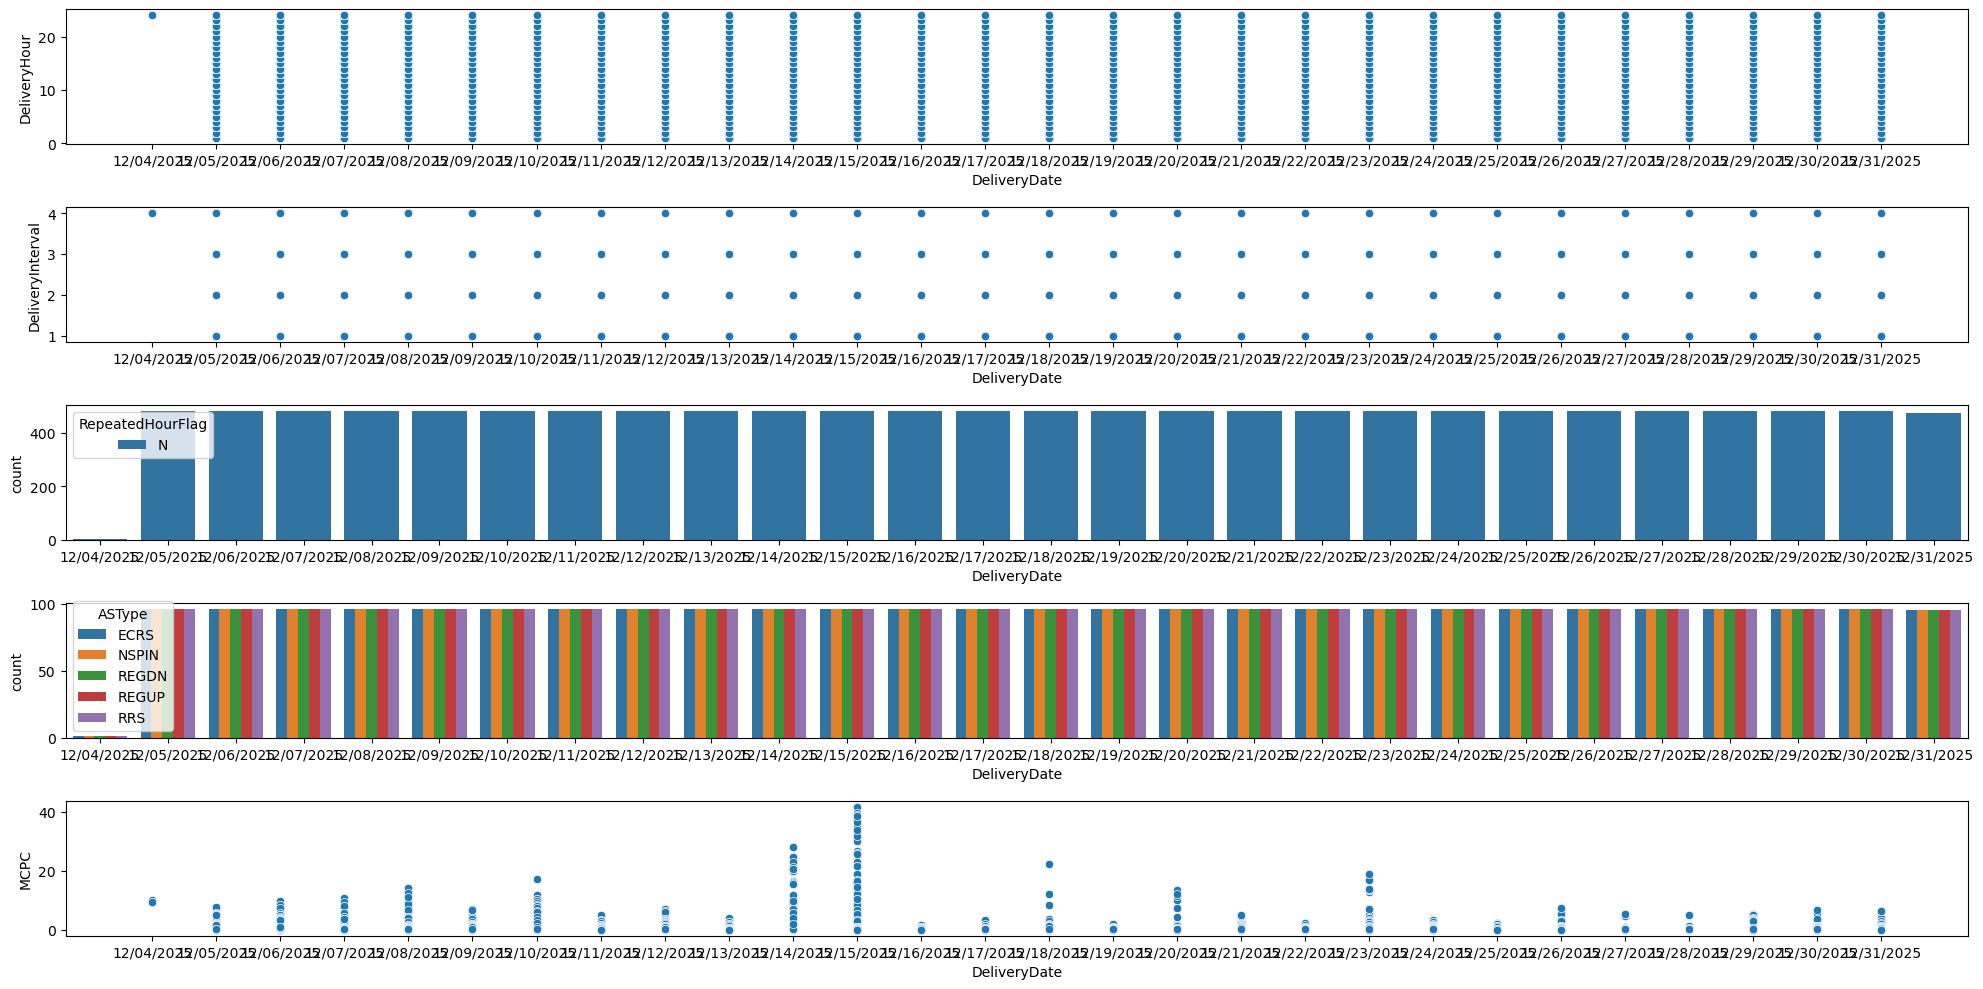

In [6]:
# Create a 2x2 grid
fig, axes = plt.subplots(5, 1, figsize=(20, 10))

# Top Left
sns.scatterplot(data=df, x="DeliveryDate", y="DeliveryHour", ax=axes[0])

# Top Right
sns.scatterplot(data=df, x="DeliveryDate", y="DeliveryInterval", ax=axes[1])

# Bottom Left
sns.countplot(data=df, x="DeliveryDate",hue="RepeatedHourFlag",ax=axes[2])

# Bottom Right
sns.countplot(data=df, x="DeliveryDate", hue="ASType", ax=axes[3])

sns.scatterplot(data=df, x="DeliveryDate", y="MCPC", ax=axes[4])


plt.tight_layout()




This is not particulary useful. It turns out upon probing a little that ASType need to be a hue for the plots because ASType represents the various ancillary services that are being paid for.

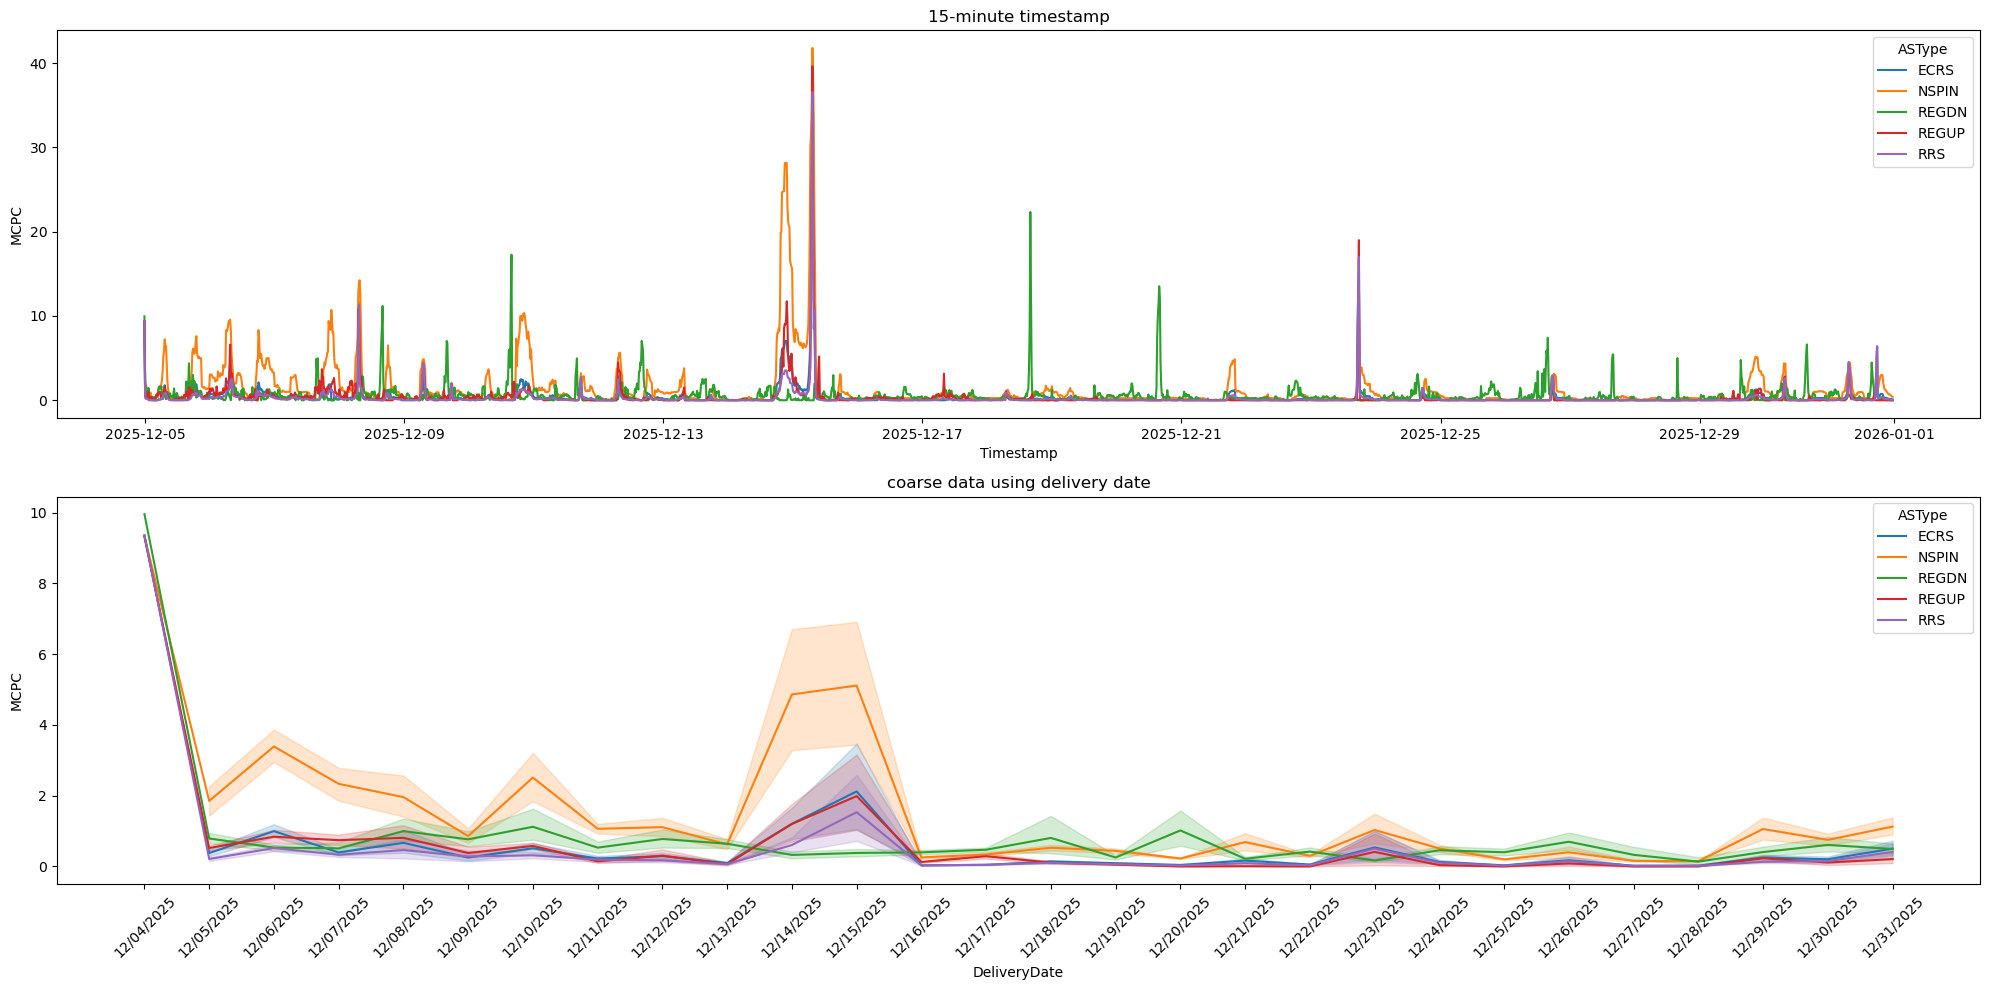

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot using 15minute timestamp
sns.lineplot(data=df, x="Timestamp", y="MCPC", hue="ASType", ax=axes[0],).set(title='15-minute timestamp')

sns.lineplot(data=df,x='DeliveryDate',y='MCPC',hue='ASType',ax=axes[1]).set(title='coarse data using delivery date')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
#for x in df['ASType'].unique():
 #   print(df.loc['ASType'==x].count())

df['ASType'].value_counts()

ASType
ECRS     2592
NSPIN    2592
REGDN    2592
REGUP    2592
RRS      2592
Name: count, dtype: int64

In [8]:
dg = data_dict[list[1]]
dg.columns


Index(['OperDay', 'HourEnding', 'NORTH', 'SOUTH', 'WEST', 'HOUSTON', 'TOTAL',
       'DSTFlag'],
      dtype='str')

This Dataset contains information about the actual load in real time

We will make a plot of the actual load for the various region and a separate one for the Houston area.

In [28]:
dg.loc[dg['HourEnding']=='24:00','HourEnding'] = '00:00'

dg['Date'] = dg['OperDay'] +' '+ dg['HourEnding']



dg['Date'] = pd.to_datetime(dg['Date'], format="%m/%d/%Y %H:%M")
dg = dg.sort_values(by="Date", ascending=True)

dg.sample(5)

,OperDay,HourEnding,NORTH,SOUTH,WEST,HOUSTON,TOTAL,DSTFlag,Date
460,12/20/2025,05:00,14894.42,10708.75,9042.49,10421.64,45067.30,N,2025-12-20 05:00:00
372,12/16/2025,13:00,17909.63,13216.24,9606.11,12204.33,52936.31,N,2025-12-16 13:00:00
319,12/14/2025,08:00,19437.75,10870.11,9943.26,10202.12,50453.24,N,2025-12-14 08:00:00
500,12/21/2025,21:00,15486.46,12825.78,9749.94,12872.96,50935.15,N,2025-12-21 21:00:00
87,12/03/2025,16:00,17293.96,12993.67,9701.95,12828.27,52817.86,N,2025-12-03 16:00:00


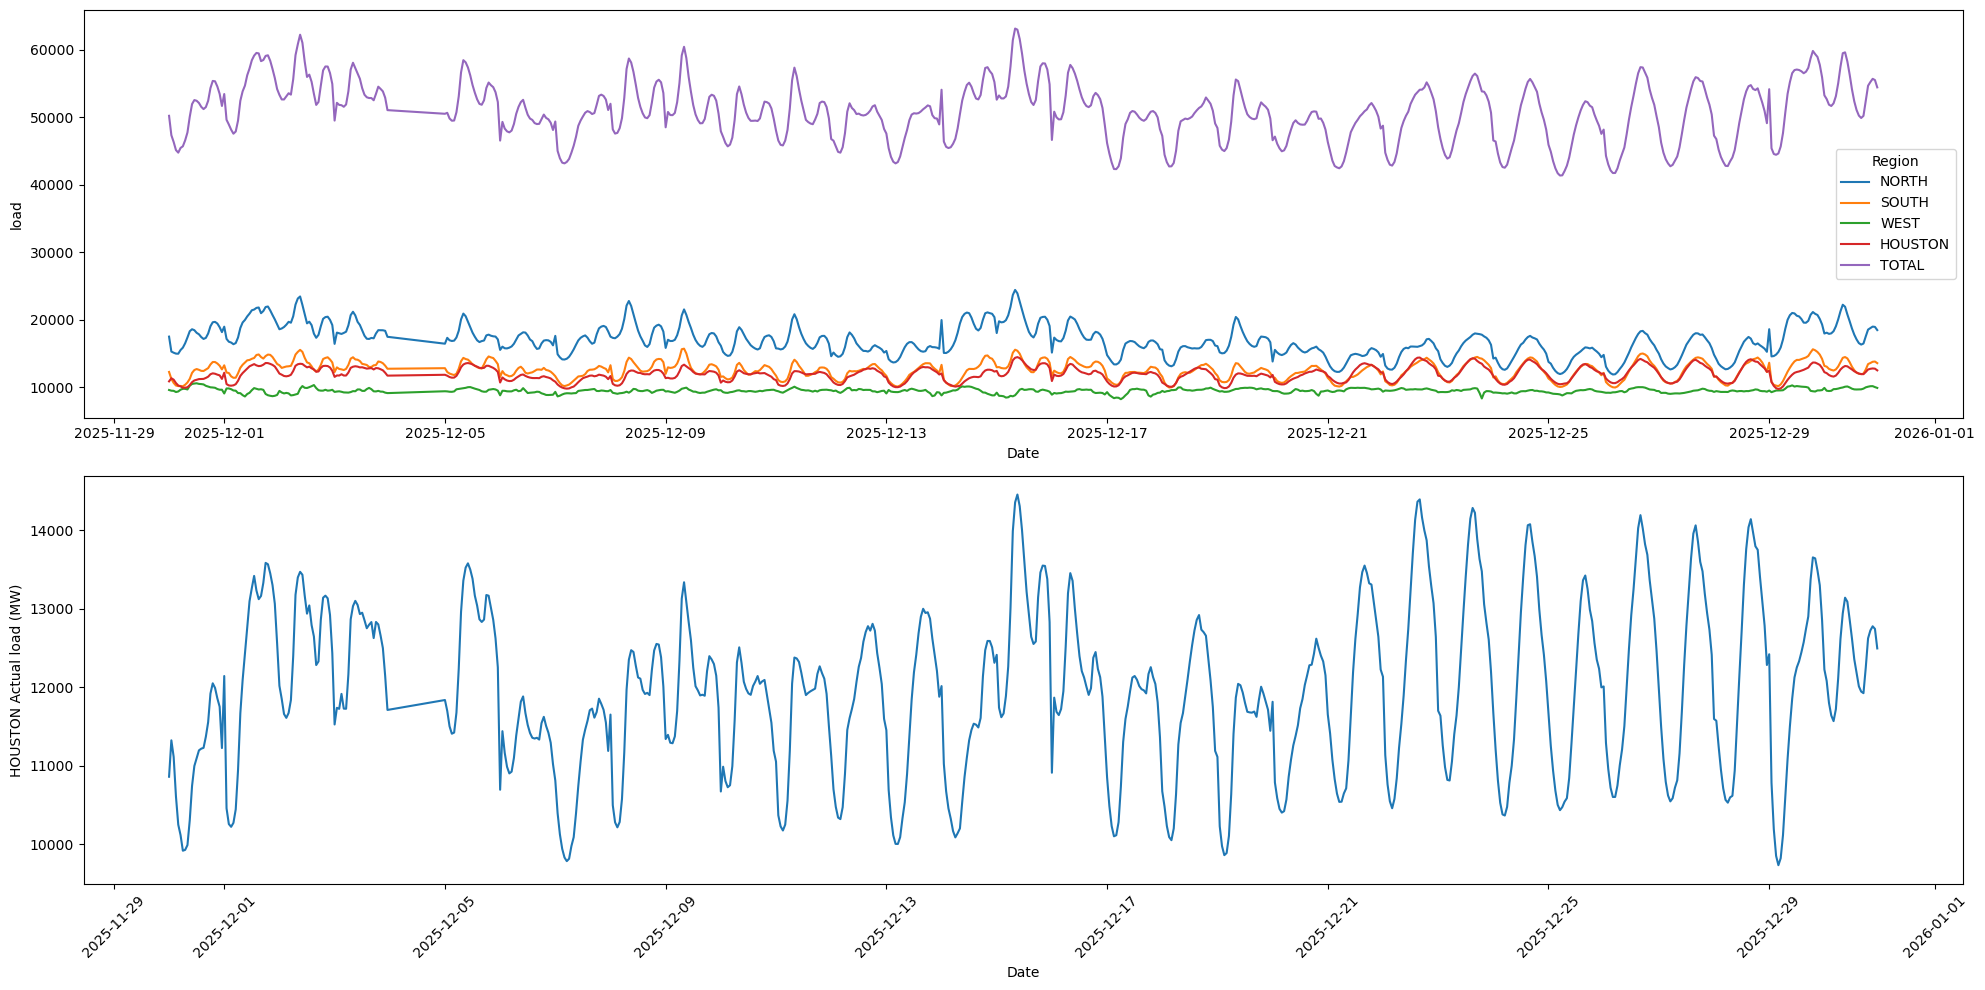

In [29]:
melt = pd.melt(dg[['Date','NORTH','SOUTH','WEST','HOUSTON','TOTAL']], id_vars='Date',var_name='Region',value_name='load')

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(melt, x='Date',y='load',hue='Region', ax=axes[0])
sns.lineplot(dg,x='Date',y='HOUSTON',ax=axes[1])

plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('HOUSTON Actual load (MW)')

plt.show()

In [30]:
dg2 = data_dict[list[2]]
dg3 = data_dict[list[3]]

dg2.columns, dg3.columns


(Index(['SCEDTimestamp', 'RepeatedHourFlag', 'SettlementPoint', 'LMP'], dtype='str'),
 Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval',
        'SettlementPointName', 'SettlementPointType', 'SettlementPointPrice',
        'DSTFlag', 'Timestamp'],
       dtype='str'))

In [12]:
print(
    dg3.sample(10),
    dg3.SettlementPointName.unique())

        DeliveryDate  DeliveryHour  DeliveryInterval SettlementPointName  \
2482360   12/24/2025            20                 4            HB_SOUTH   
2964362   12/29/2025            10                 1          ANCHOR_ALL   
3154823   12/31/2025             6                 3           TXCTY_CTB   
1270003   12/13/2025             5                 1        CALAVER_OWS1   
436723    12/05/2025             5                 1         HLSES_UNIT4   
2064371   12/20/2025            20                 4         MGSES_CT123   
1352196   12/13/2025            24                 2            NBOHR_RN   
2435843   12/24/2025             9                 3         PINN_SLR_RN   
270043    12/03/2025            15                 4           LNCRK_ALL   
11243     12/01/2025             3                 3        GREASWOD_ALL   

        SettlementPointType  SettlementPointPrice DSTFlag  
2482360                  HU                 19.89       N  
2964362                  RN                

<i>We have to figure out what the various settlement point names are, and narrow down our search to Houston area.</i>

In [31]:
print(dg3['SettlementPointName'][dg3['SettlementPointName'].str.contains('Houston',case=False)].unique())

dg3['Timestamp']= pd.to_datetime(dg3['DeliveryDate'])

dg3['Timestamp'] += pd.to_timedelta(dg3['DeliveryHour'] - 1, unit='h')
dg3['Timestamp'] += pd.to_timedelta((dg3['DeliveryInterval'] - 1) * 15, unit='m')

dg3 = dg3.sort_values(by="Timestamp", ascending=True)

#dg3.head(5), dg3.tail(5)

dg3.SettlementPointType.unique()



<ArrowStringArray>
['HB_HOUSTON', 'LZ_HOUSTON']
Length: 2, dtype: str


<ArrowStringArray>
[     'RN',   'LCCRN',   'PCCRN',     'PUN',    'LZEW',      'LZ', 'LZ_DCEW',
   'LZ_DC',      'SH',      'HU',      'AH']
Length: 11, dtype: str

In [ ]:
#Takes too long to run and doesn't produce very helpful information. But I have left it here in case this needs to be looked at.

#sns.scatterplot(dg3,x='Timestamp',y='SettlementPointPrice',hue='SettlementPointType')

C:\Users\Quarantine\AppData\Local\Temp\ipykernel_25656\486628100.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


Error in callback <function _draw_all_if_interactive at 0x000001BF4443A0C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001BF98C84A40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

<Axes: xlabel='Timestamp', ylabel='SettlementPointPrice'>

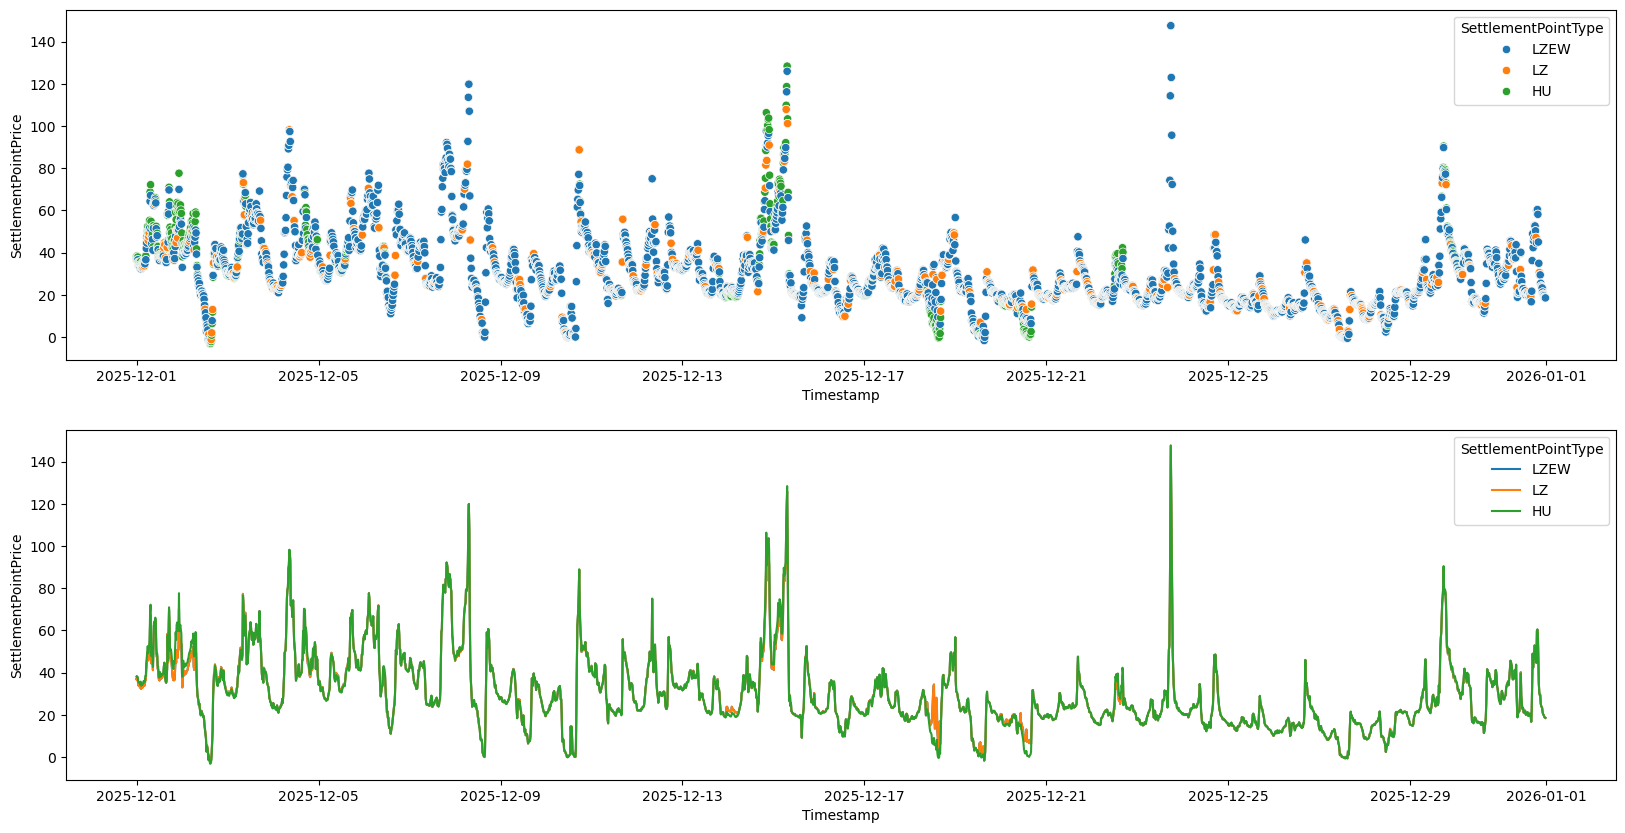

In [32]:

dg3Houston = dg3[(dg3['SettlementPointName']=='HB_HOUSTON') | (dg3['SettlementPointName']== 'LZ_HOUSTON')]

#dg3Houston.sample(5)

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.scatterplot(dg3Houston,x='Timestamp',y='SettlementPointPrice',hue='SettlementPointType',ax=axes[0])
sns.lineplot(dg3Houston,x='Timestamp',y='SettlementPointPrice',hue='SettlementPointType', ax=axes[1])


I don't understand what's happening with the data here: why are the scatterplot and lineplot giving seemingly different results?

In [25]:
# This is the last NP6 dataset

dg2['SCEDTimestamp']= pd.to_datetime(dg2['SCEDTimestamp'])
dg2 = dg2.sort_values(by="SCEDTimestamp", ascending=True)

dg2.head(5), dg2['SettlementPoint'][dg2['SettlementPoint'].str.contains('Houston',case=False)].unique()




#dg2.SCEDTimestamp.nunique(),(dg2.SettlementPoint == '7RNCHSLR_ALL').sum()

(          SCEDTimestamp RepeatedHourFlag SettlementPoint    LMP
 0   2025-12-01 00:00:14                N    7RNCHSLR_ALL  52.79
 705 2025-12-01 00:00:14                N     PALACIOS_RN  37.40
 706 2025-12-01 00:00:14                N     PALE_ESS_EN  75.35
 707 2025-12-01 00:00:14                N     PALMVIEW_RN  -1.44
 708 2025-12-01 00:00:14                N    PALMWI_UNIT1  -2.36,
 <ArrowStringArray>
 ['LZ_HOUSTON', 'HB_HOUSTON']
 Length: 2, dtype: str)

<Axes: xlabel='SCEDTimestamp', ylabel='LMP'>

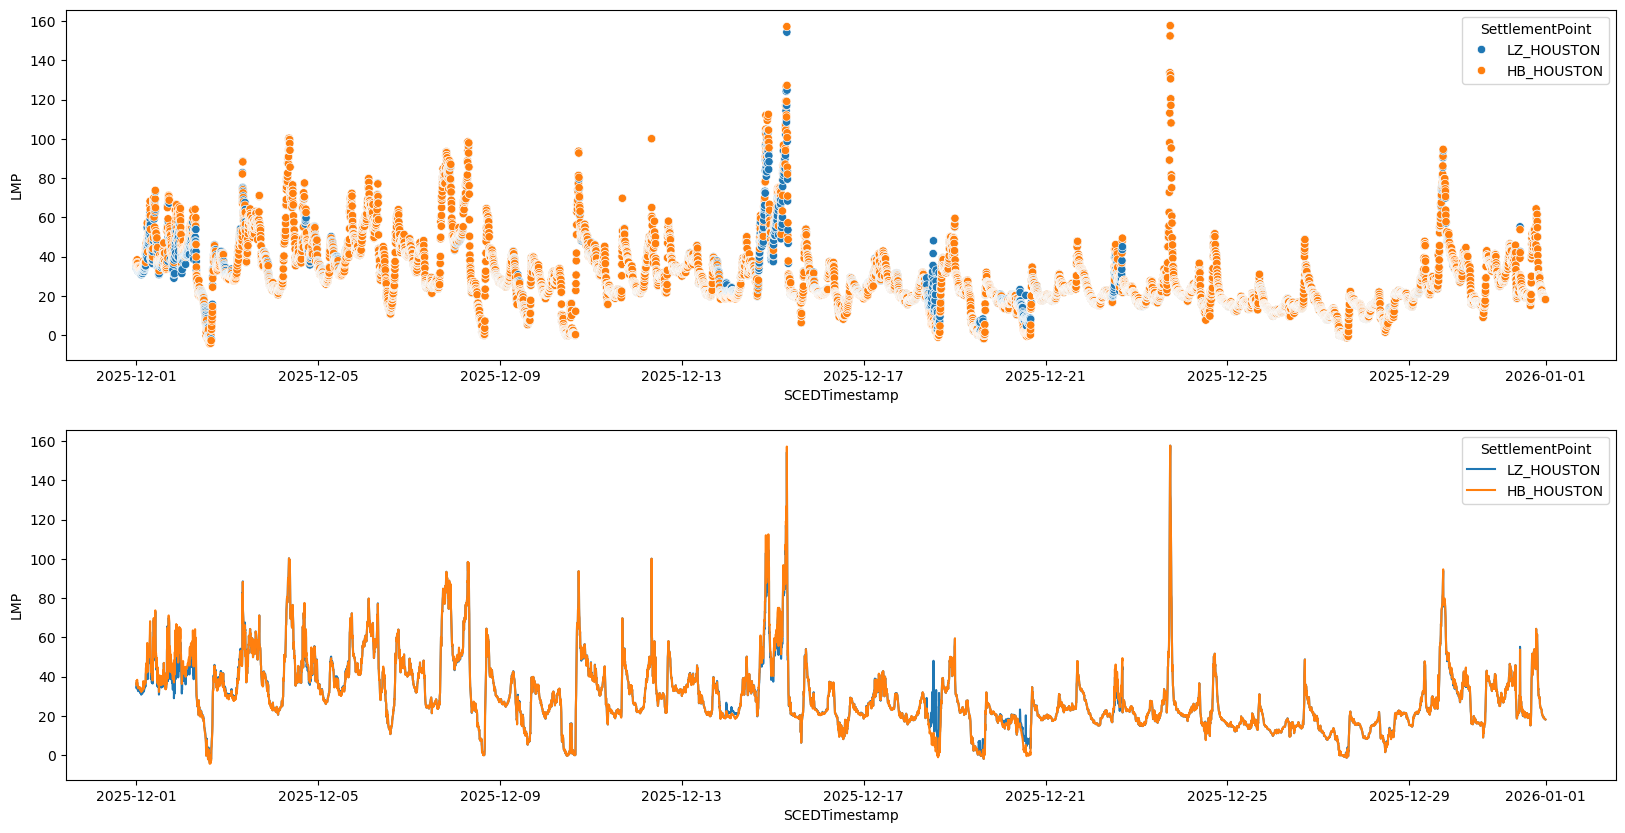

In [ ]:
dg2Houston = dg2[(dg2['SettlementPoint']=='HB_HOUSTON') | (dg2['SettlementPoint']== 'LZ_HOUSTON')]


dg2Houston.sample(5)

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.scatterplot(dg2Houston,x='SCEDTimestamp',y='LMP',hue='SettlementPoint',ax=axes[0])
sns.lineplot(dg2Houston,x='SCEDTimestamp',y='LMP',hue='SettlementPoint', ax=axes[1])



In [33]:
#Using these from Eric's file

DAM_system_lambda = pd.read_csv('data/sample/ercot/NP4-523-CD/2025/12/NP4-523-CD_202512.csv')
wind = pd.read_csv('data/sample/ercot/NP4-732-CD/2025/12/NP4-732-CD_202512.csv')
solar = pd.read_csv('data/sample/ercot/NP4-745-CD/2025/12/NP4-745-CD_202512.csv')


In [48]:
#print(DAM_system_lambda.sample(5))
wind.columns

Index(['DELIVERY_DATE', 'HOUR_ENDING', 'SYSTEM_WIDE_GEN',
       'COP_HSL_SYSTEM_WIDE', 'STWPF_SYSTEM_WIDE', 'WGRPP_SYSTEM_WIDE',
       'GEN_LZ_SOUTH_HOUSTON', 'COP_HSL_LZ_SOUTH_HOUSTON',
       'STWPF_LZ_SOUTH_HOUSTON', 'WGRPP_LZ_SOUTH_HOUSTON', 'GEN_LZ_WEST',
       'COP_HSL_LZ_WEST', 'STWPF_LZ_WEST', 'WGRPP_LZ_WEST', 'GEN_LZ_NORTH',
       'COP_HSL_LZ_NORTH', 'STWPF_LZ_NORTH', 'WGRPP_LZ_NORTH',
       'SYSTEM_WIDE_HSL', 'DSTFlag'],
      dtype='str')

In [47]:
solar.columns

Index(['DELIVERY_DATE', 'HOUR_ENDING', 'SYSTEM_WIDE_GEN',
       'COP_HSL_SYSTEM_WIDE', 'STPPF_SYSTEM_WIDE', 'PVGRPP_SYSTEM_WIDE',
       'GEN_CenterWest', 'COP_HSL_CenterWest', 'STPPF_CenterWest',
       'PVGRPP_CenterWest', 'GEN_NorthWest', 'COP_HSL_NorthWest',
       'STPPF_NorthWest', 'PVGRPP_NorthWest', 'GEN_FarWest', 'COP_HSL_FarWest',
       'STPPF_FarWest', 'PVGRPP_FarWest', 'GEN_FarEast', 'COP_HSL_FarEast',
       'STPPF_FarEast', 'PVGRPP_FarEast', 'GEN_SouthEast', 'COP_HSL_SouthEast',
       'STPPF_SouthEast', 'PVGRPP_SouthEast', 'GEN_CenterEast',
       'COP_HSL_CenterEast', 'STPPF_CenterEast', 'PVGRPP_CenterEast',
       'SYSTEM_WIDE_HSL', 'DSTFlag'],
      dtype='str')